**@author: James V. Talwar**

# HLA Supertype Analysis: Supertype and Age of Diagnosis in SKCM TCGA Patients 

**About:** This notebook provides the code needed to generate **Supplementary Figure 7** from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses investigated the effect of HLA supertype (class I) on age of diagnosis in TCGA skin cutaneous melanoma (SKCM) cases. 

## 1. Import Packages; Load Data

In [1]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in TCGA summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [3]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

Load in HLA supertypes:

In [4]:
path = '../Data/Class_I_Supertypes/'
files = os.listdir(path)
superTypes = defaultdict(set)
for file in files:
    temp = pd.read_csv(os.path.join(path, file), header = None)
    superTypes[file] = set(temp.iloc[:, 0])

## 2. Data Processing and Formatting:

Map each SKCM TCGA individual to all potential supertypes they contain. *Note that since supertypes don't include HLA-C these supertype mappings focus on HLA-A and HLA-B.*

In [5]:
superTypeMapping = defaultdict(lambda: defaultdict(bool))
for i,row in tcgaSummary.iterrows():
    mhcGenotype = set(row["A1":"B2"]) 
    for sup, alleles in sorted(superTypes.items()):
        superTypeMapping[i][sup] = len(mhcGenotype.intersection(alleles)) > 0

Merge supertype information with TCGA summary dataframe:

In [6]:
tcgaSummary = pd.concat([tcgaSummary, pd.DataFrame(superTypeMapping).T], axis = 1)

Reformat summary dataframe in a compatible format for visualization/plotting:

In [7]:
forPlottingViz = defaultdict(list)
for col in sorted(superTypes):
    for i,row in tcgaSummary.iterrows():
        forPlottingViz["ID"].append(i)
        forPlottingViz["Age"].append(row["Age"])
        forPlottingViz["Sex"].append(row["Sex"])
        forPlottingViz["SuperType"].append(col)
        forPlottingViz["HasSuperType"].append(row[col])
seabornCompatibleDF = pd.DataFrame(forPlottingViz)

## 3. Run Analyses and Generate Figure:

Do any supertypes show significant age differences?

In [8]:
uncorrectedSignificances = defaultdict(float)
for col in sorted(superTypes):
    _ , p = mannwhitneyu(tcgaSummary[tcgaSummary[col] == False].Age, tcgaSummary[tcgaSummary[col]].Age)
    uncorrectedSignificances[col] = p

Run MH correction:

In [9]:
print("Before MH-correction the MWU p values are as follows: {}".format(sorted(uncorrectedSignificances.items(), key = lambda x: x[1])))

Before MH-correction the MWU p values are as follows: [('B44', 0.015273046798791866), ('A02', 0.07951903397927812), ('unclassified', 0.17647837959409357), ('A01', 0.18967393860751514), ('B58', 0.2284133560503378), ('B07', 0.3389113564639759), ('B27', 0.3724317902154276), ('A01_A24', 0.3902244040668289), ('B62', 0.4059537432879638), ('A01_A03', 0.4687324538822203), ('A24', 0.47104779854612566), ('A03', 0.4740290664446913), ('B08', 0.48029091023837217)]


In [10]:
mhTesting = multipletests(pvals = [el[1] for el in sorted(uncorrectedSignificances.items(), key = lambda x: x[1])], alpha = 0.1, method = 'fdr_bh')
mhTesting

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False]),
 array([0.19854961, 0.48029091, 0.48029091, 0.48029091, 0.48029091,
        0.48029091, 0.48029091, 0.48029091, 0.48029091, 0.48029091,
        0.48029091, 0.48029091, 0.48029091]),
 0.008071900880671112,
 0.007692307692307693)

In [11]:
correctedPVals = dict(zip([el[0] for el in sorted(uncorrectedSignificances.items(), key = lambda x: x[1])], mhTesting[1]))
correctedPVals

{'B44': 0.19854960838429425,
 'A02': 0.48029091023837217,
 'unclassified': 0.48029091023837217,
 'A01': 0.48029091023837217,
 'B58': 0.48029091023837217,
 'B07': 0.48029091023837217,
 'B27': 0.48029091023837217,
 'A01_A24': 0.48029091023837217,
 'B62': 0.48029091023837217,
 'A01_A03': 0.48029091023837217,
 'A24': 0.48029091023837217,
 'A03': 0.48029091023837217,
 'B08': 0.48029091023837217}

Generate figure:

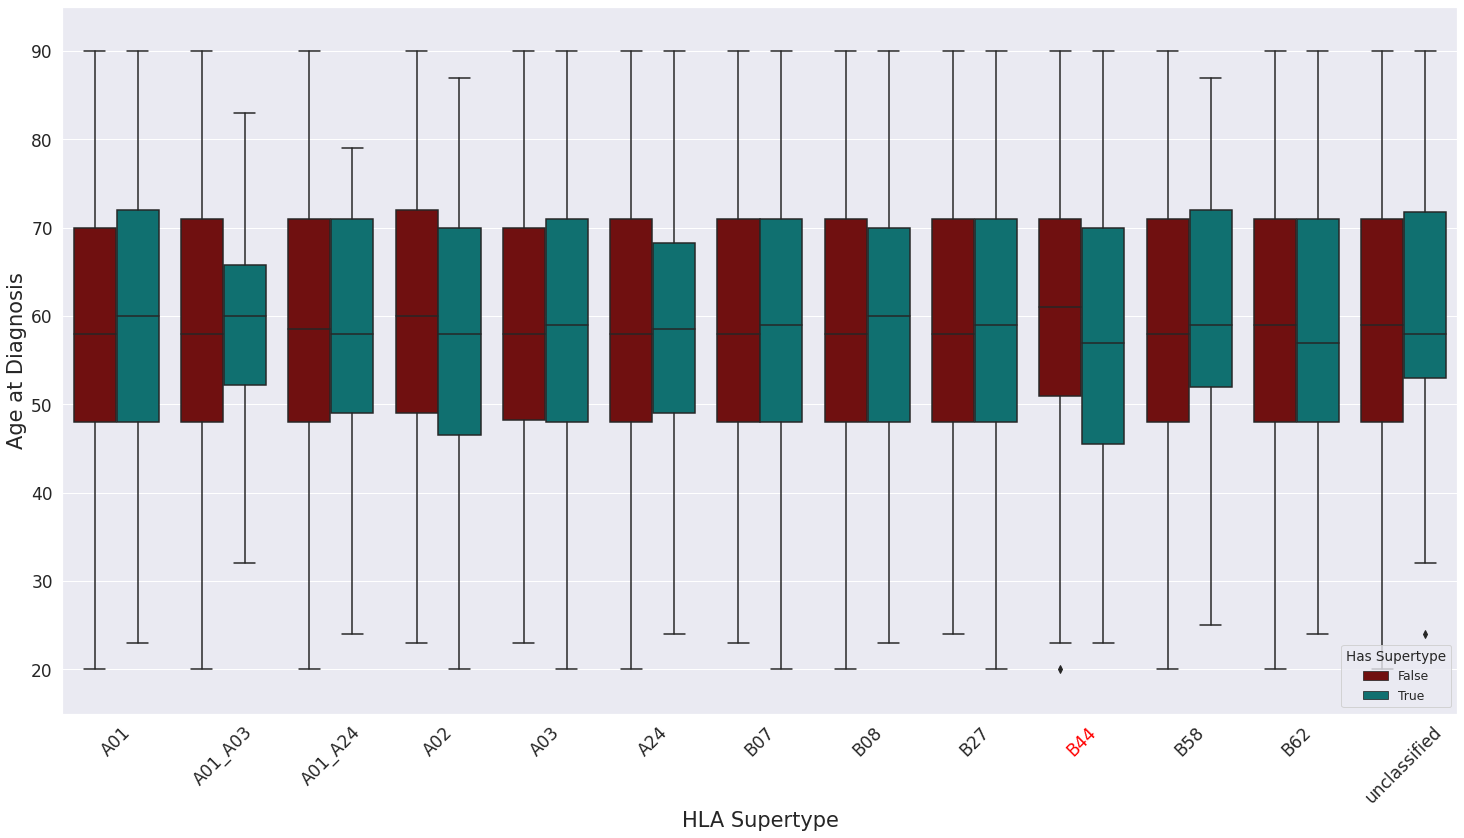

In [12]:
sns.set(font_scale = 1.1)
supertypePalette = {False: "maroon", True:"teal"}
fig, ax = plt.subplots(figsize=(25,13))
sns.set(font_scale=1.13)
sns.boxplot(data = seabornCompatibleDF, y = "Age", hue = "HasSuperType", x = "SuperType", palette = supertypePalette)
plt.xticks(rotation = 45, fontsize = 17)
plt.yticks(fontsize = 17)
plt.ylim(15,95)

plt.legend(title = "Has Supertype", loc = 4)
plt.xlabel('HLA Supertype', fontsize = 21)
plt.ylabel("Age at Diagnosis", fontsize = 21)

for i in range(len(ax.get_xticklabels())):
    if ax.get_xticklabels()[i].get_text() == "B44":
        ax.get_xticklabels()[i].set_color("red")

Age difference gap in B44 supertype:

In [13]:
print("B44 carrier median age: {}".format(np.median(tcgaSummary[tcgaSummary["B44"]].Age)))
print("B44 non-carrier median age: {}".format(np.median(tcgaSummary[tcgaSummary["B44"] == False].Age)))

B44 carrier median age: 57.0
B44 non-carrier median age: 61.0
